### Ingest Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report 
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/erinmcmahon26/Company-Bankruptcy-Prediction-Kaggle/main/company_bankruptcy.csv')

In [4]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

### EDA

Going to compare using SMOTE vs the full dataset for the below models to see how the models perform. Then use the individual model feature selection to further assess what data should and should not be included.

In [5]:
y = df['Bankrupt?']
X = df.drop('Bankrupt?', axis=1)

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.astype(np.float64))

In [7]:
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [8]:
X, y = pipeline.fit_resample(X_scaled, y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

### Models

In [10]:
def model_metrics(model, xtest, ytest):
  y_pred = model.predict(xtest)
  cm = confusion_matrix(ytest, y_pred)
  print("Accuracy Score:", accuracy_score(ytest, y_pred))
  print("Report:", classification_report(ytest, y_pred))
  sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")

In [11]:
def param_selection(model, parameters, xtrain, ytrain):
  grid_search = RandomizedSearchCV(model, parameters, scoring='accuracy', cv=5, n_jobs=1)
  results = grid_search.fit(xtrain, ytrain)
  print('Mean Accuracy: %.3f' % results.best_score_)
  print('Config: %s' % results.best_params_)

I will be using RandomizedSearchCV for these models as GridSearchCV was taking a very long time to run. 

In [12]:
def acc_score(model, input_data, output_data):
    return np.mean(cross_val_score(model,input_data,output_data,cv=5,scoring="accuracy"))

#### Decision Tree



Accuracy Score: 0.9454545454545454
Report:               precision    recall  f1-score   support

           0       0.96      0.95      0.96      1092
           1       0.92      0.94      0.93       668

    accuracy                           0.95      1760
   macro avg       0.94      0.95      0.94      1760
weighted avg       0.95      0.95      0.95      1760



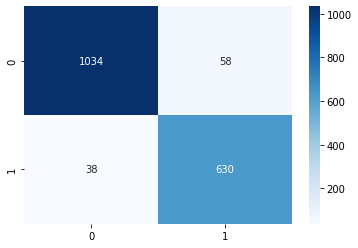

In [13]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

model_metrics(clf, X_test, y_test)

[Text(0.5161266222677595, 0.9852941176470589, 'X[9] <= 0.014\ngini = 0.468\nsamples = 7037\nvalue = [4406, 2631]'),
 Text(0.26075819672131145, 0.9558823529411765, 'X[36] <= 0.728\ngini = 0.416\nsamples = 3222\nvalue = [952, 2270]'),
 Text(0.10126366120218579, 0.9264705882352942, 'X[90] <= -0.143\ngini = 0.462\nsamples = 1076\nvalue = [686, 390]'),
 Text(0.04371584699453552, 0.8970588235294118, 'X[85] <= -2.701\ngini = 0.172\nsamples = 400\nvalue = [362, 38]'),
 Text(0.02185792349726776, 0.8676470588235294, 'X[54] <= 0.348\ngini = 0.464\nsamples = 41\nvalue = [15, 26]'),
 Text(0.01092896174863388, 0.8382352941176471, 'X[18] <= -1.447\ngini = 0.355\nsamples = 13\nvalue = [10, 3]'),
 Text(0.00546448087431694, 0.8088235294117647, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.01639344262295082, 0.8088235294117647, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]'),
 Text(0.03278688524590164, 0.8382352941176471, 'X[91] <= -0.048\ngini = 0.293\nsamples = 28\nvalue = [5, 23]'),
 Text(0.0273224

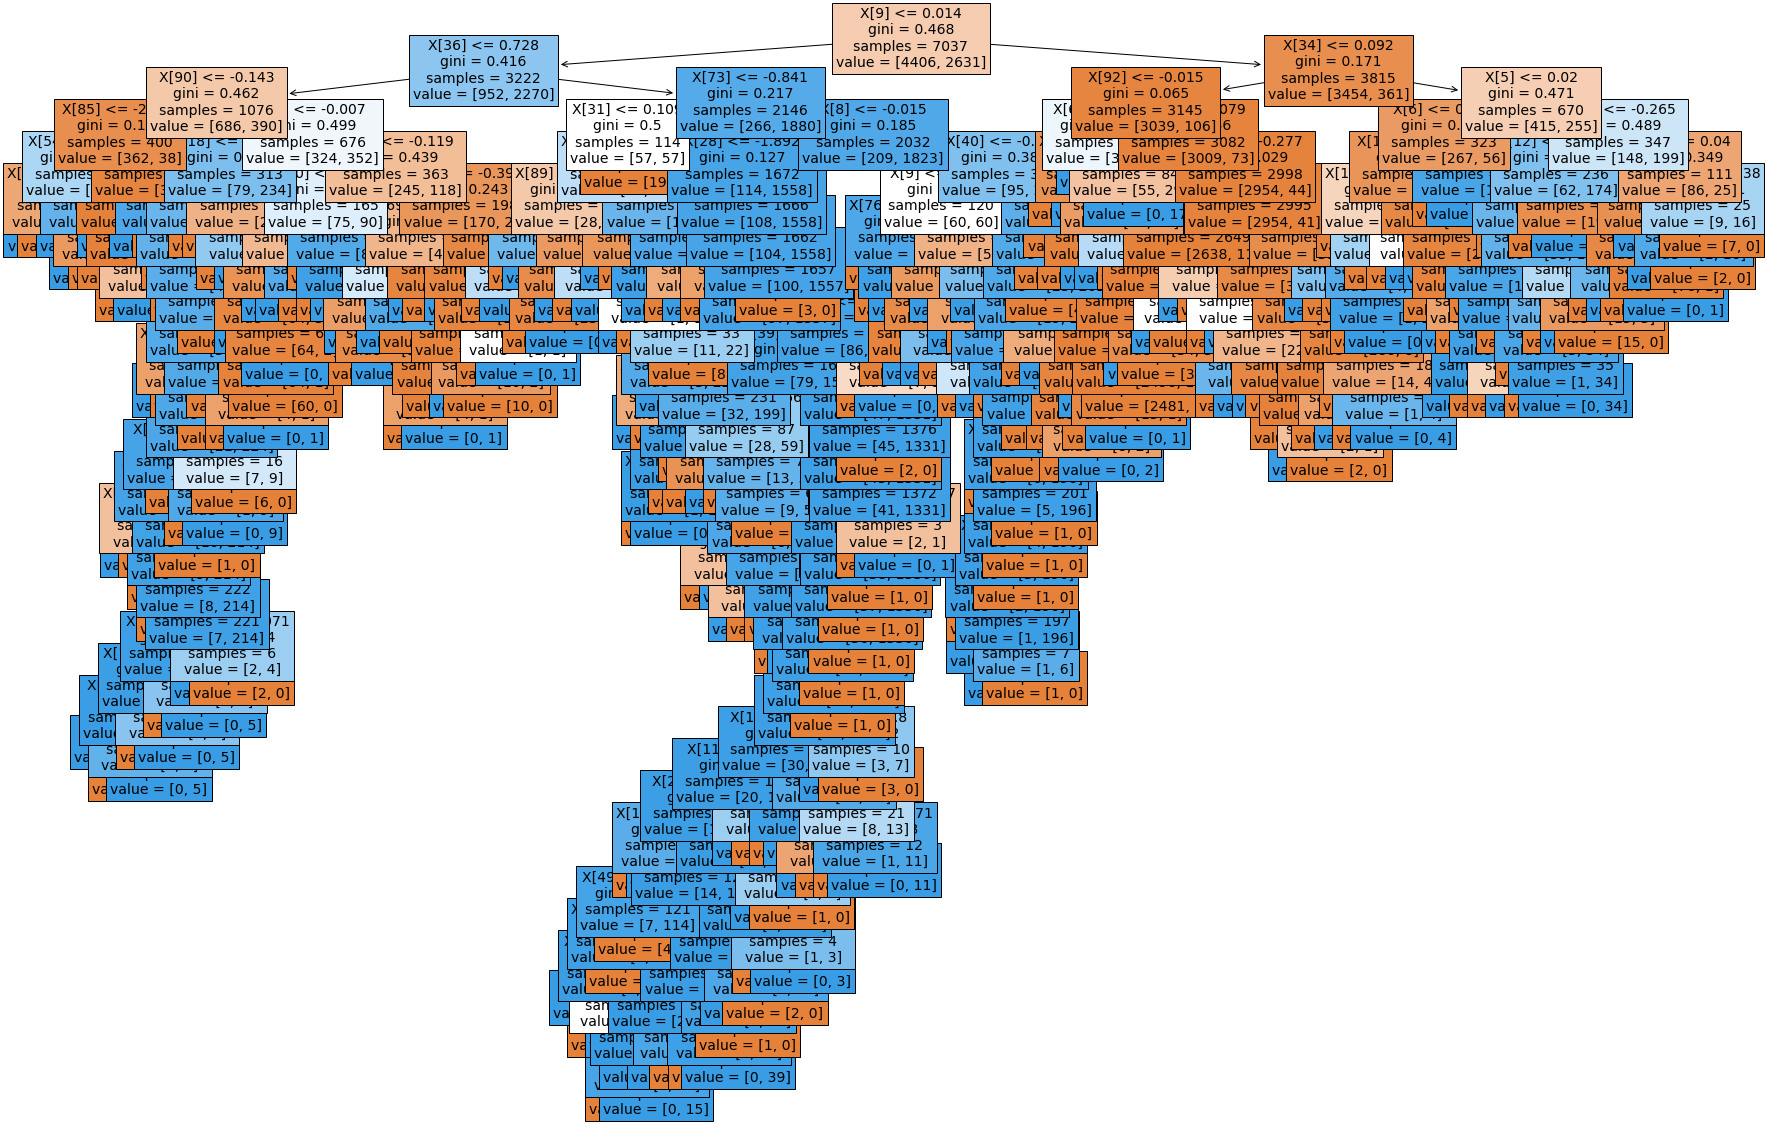

In [14]:
# can adjust min_impurity_decrease=# to decrease the 
from sklearn import tree
%matplotlib inline
plt.figure(figsize=(30,20))
tree.plot_tree(clf, filled=True, fontsize=14)

Gini versus Entropy: gini basically measures the randomness of impurity (impurity increases with randomness) whereas entropy measures the uncertainty/randomness (more random, the higher the entropy). Most of the time these produce similar trees but while gini is the default and is often slightly faster, entropy can produce slightly more balanced trees when these two parameters produce a difference. 

Max_depth: signifies when the model stops splitting which helps regularize the model to reduce the risk of overfitting. Default = 0

Min_samples_leaf: the minimum number of samples a leaf node must have aka a split can only happen if it leaves the minimum about of samples per leaf in both of the resulting nodes. Default = 1

Min_samples_split: the minimum number of samples required to split an internal node, if the sample has less than this number it will become a leaf node. Default = 2

##### PCA for Feature Selection

In [15]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components=95)
pca_test.fit(X_train)
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr

In [16]:
pca_df.loc[pca_df['Cumulative Variance Ratio'] <= 0.95]

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.241908,0.241908
1,0.377236,0.135328
2,0.426986,0.049750
3,0.470752,0.043766
4,0.509932,0.039180
5,0.542626,0.032694
6,0.568514,0.025888
7,0.593782,0.025268
8,0.617008,0.023226
9,0.638333,0.021324


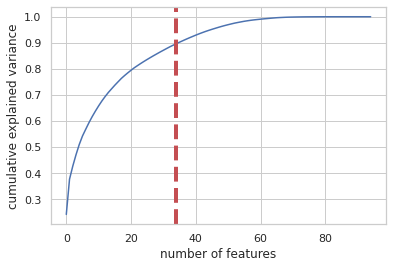

None

In [17]:
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of features')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=34, ymin=0, ymax=1)
display(plt.show())

With scaling the features and using SMOTE, we see that 34 columns represent 95% of the variance in the data set. 

In [19]:
pca = PCA(n_components=34)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Accuracy Score: 0.9176136363636364
Report:               precision    recall  f1-score   support

           0       0.95      0.91      0.93      1092
           1       0.87      0.93      0.90       668

    accuracy                           0.92      1760
   macro avg       0.91      0.92      0.91      1760
weighted avg       0.92      0.92      0.92      1760



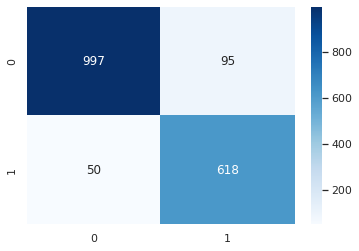

In [20]:
clf = DecisionTreeClassifier()
clf.fit(X_train_pca,y_train)

model_metrics(clf, X_test_pca, y_test)

In [23]:
# check for overfitting and underfitting
# average accuracy
print('Training set score: {:.4f}'.format(clf.score(X_train_pca, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_test_pca, y_test)))

Training set score: 1.0000
Test set score: 0.9176


In [24]:
parameters = [{ 'criterion': ['gini', 'entropy'],
                 'max_depth': range(1,10),
                 'min_samples_split': range(1,10),
                 'min_samples_leaf': range(1,5)}]

param_selection(clf, parameters, X_train, y_train)

Mean Accuracy: 0.913
Config: {'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 6, 'criterion': 'gini'}


#### Extra Tree Classifier

Accuracy Score: 0.9806818181818182
Report:               precision    recall  f1-score   support

           0       1.00      0.97      0.98      1092
           1       0.96      0.99      0.97       668

    accuracy                           0.98      1760
   macro avg       0.98      0.98      0.98      1760
weighted avg       0.98      0.98      0.98      1760



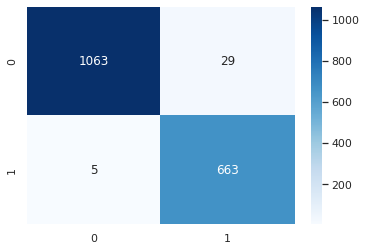

In [25]:
et = ExtraTreesClassifier()
et.fit(X_train, y_train)

model_metrics(et, X_test, y_test)

In [26]:
# check for overfitting and underfitting
# average accuracy
print('Training set score: {:.4f}'.format(et.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(et.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.9807


In [28]:
parameters4 = [{'n_estimators': range(50,126,25),
                'max_features': range(0,200,50),
                'min_samples_leaf': range(20,50,5),
                'min_samples_split': range(15,36,5)}]
param_selection(et, parameters4, X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/para

Mean Accuracy: 0.926
Config: {'n_estimators': 50, 'min_samples_split': 25, 'min_samples_leaf': 20, 'max_features': 50}


Extra Trees trade more bias for lower variance as it uses random thresholds for each features rather than searching for the best possible threshold like Decision Tree's do. This model is performing as well, if not slightly better than the Decision Tree.

#### Random Forest

Accuracy Score: 0.9727272727272728
Report:               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1092
           1       0.95      0.98      0.96       668

    accuracy                           0.97      1760
   macro avg       0.97      0.97      0.97      1760
weighted avg       0.97      0.97      0.97      1760



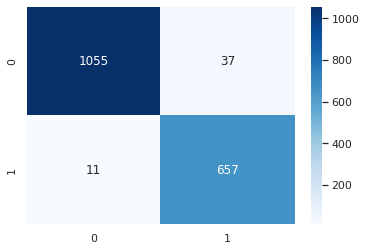

In [29]:
rfc = RandomForestClassifier(n_estimators=100, random_state = 777)
rfc.fit(X_train, y_train)

model_metrics(rfc, X_test, y_test)

In [30]:
# check for overfitting and underfitting
# average accuracy
print('Training set score: {:.4f}'.format(rfc.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(rfc.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.9727


In [31]:
df_features = df.drop(['Bankrupt?'], axis = 1)

In [32]:
feature_imp = pd.Series(rfc.feature_importances_,index=df_features.columns).sort_values(ascending=False)
feature_imp

 Borrowing dependency                       0.060415
 Continuous interest rate (after tax)       0.043562
 After-tax net Interest Rate                0.043308
 Net Income to Total Assets                 0.040673
 Persistent EPS in the Last Four Seasons    0.040031
                                              ...   
 Revenue Per Share (Yuan ¥)                 0.000000
 Quick Assets/Current Liability             0.000000
 Current Ratio                              0.000000
 Net Value Growth Rate                      0.000000
 Net Income Flag                            0.000000
Length: 95, dtype: float64

Random Forests are able to measure feature importance by looking at how much nodes that use specific features, reduce impurity on average across all trees. Based on our dataset, the features we have to work with do not have a high importance to Bankrupt?

In [33]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = [{'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}]


param_selection(rfc, random_grid, X_train, y_train)

Mean Accuracy: 0.974
Config: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False}


#### Gradient Boosted Classifier

Accuracy Score: 0.9454545454545454
Report:               precision    recall  f1-score   support

           0       0.96      0.95      0.96      1092
           1       0.92      0.94      0.93       668

    accuracy                           0.95      1760
   macro avg       0.94      0.95      0.94      1760
weighted avg       0.95      0.95      0.95      1760



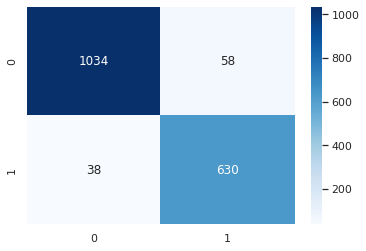

In [34]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

model_metrics(gb, X_test, y_test)

In [35]:
# check for overfitting and underfitting
# average accuracy
print('Training set score: {:.4f}'.format(gb.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(gb.score(X_test, y_test)))

Training set score: 0.9713
Test set score: 0.9455


In [36]:
parameters2 = [{"n_estimators":[5,50,250,500],
                "max_depth":[1,3,5,7,9],
                "learning_rate":[0.01,0.1,1,10,100]}]
param_selection(gb, parameters2, X_train, y_train)

Mean Accuracy: 0.979
Config: {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.1}


Gradient Boosting is another ensemble method that sequentially adds predictors, each predictor correcting its predecessor. Gradient boosting tries to fit the new predictor to the residual errors made by the previous predictors. 

### Conclusions

In [37]:
# for training data
Classifiers=["Decision Tree","Extra Trees Classifier","Random Forest Classifier","Gradiant Boosted"]
Acc=[acc_score(x, X_train, y_train) for x in [clf, et, rfc, gb]]
cols=["Classifier","Accuracy"]
results = pd.DataFrame(columns=cols)
results["Classifier"]=Classifiers
results["Accuracy"]=Acc
results

,Classifier,Accuracy
0,Decision Tree,0.928381
1,Extra Trees Classifier,0.975416
2,Random Forest Classifier,0.968737
3,Gradiant Boosted,0.948984


In [38]:
Classifiers=["Decision Tree","Extra Trees Classifier","Random Forest Classifier","Gradiant Boosted"]
Acc=[acc_score(x, X_test, y_test) for x in [clf, et, rfc, gb]]
cols=["Classifier","Accuracy"]
results = pd.DataFrame(columns=cols)
results["Classifier"]=Classifiers
results["Accuracy"]=Acc
results

,Classifier,Accuracy
0,Decision Tree,0.894318
1,Extra Trees Classifier,0.935227
2,Random Forest Classifier,0.926705
3,Gradiant Boosted,0.923295


The F1 scores for the classes due vary by model. I think the biggest issue with this dataset is how skewed it is, which makes it hard to give the model enough data to create better predictions without using something like SMOTE or distributing the data differently. More work could have been done to assess outlier removal, but there were issues with this as well since it was depleting an already depleted dataset. 

** All detailed definitions are summarized from:

Geron, Aurelien. (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. 2nd ed. Sebastopol, CA: O'Reilly.